In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

data_dir = 'C:/Users/avp/OneDrive - HKUST Connect/Desktop/DATA/data [N=10000, p1=3, p=150, L=150, alpha=0.1, SNR=1, K=100]'

# A. Generate Data

In [2]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [3]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [4]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [5]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [6]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [7]:
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 10}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/10: 100%|██████████| 500/500 [00:02<00:00, 222.68it/s]


Epoch [1/10], Running Loss: 0.0315
Train Loss: 0.0272
Test Loss: 0.0277


Epoch 2/10: 100%|██████████| 500/500 [00:02<00:00, 221.85it/s]


Epoch [2/10], Running Loss: 0.0258
Train Loss: 0.0234
Test Loss: 0.0244


Epoch 3/10: 100%|██████████| 500/500 [00:02<00:00, 220.92it/s]


Epoch [3/10], Running Loss: 0.0223
Train Loss: 0.0203
Test Loss: 0.0212


Epoch 4/10: 100%|██████████| 500/500 [00:02<00:00, 224.78it/s]


Epoch [4/10], Running Loss: 0.0202
Train Loss: 0.0190
Test Loss: 0.0199


Epoch 5/10: 100%|██████████| 500/500 [00:02<00:00, 218.54it/s]


Epoch [5/10], Running Loss: 0.0194
Train Loss: 0.0185
Test Loss: 0.0194


Epoch 6/10: 100%|██████████| 500/500 [00:02<00:00, 224.40it/s]


Epoch [6/10], Running Loss: 0.0189
Train Loss: 0.0181
Test Loss: 0.0194


Epoch 7/10: 100%|██████████| 500/500 [00:02<00:00, 214.46it/s]


Epoch [7/10], Running Loss: 0.0185
Train Loss: 0.0177
Test Loss: 0.0195


Epoch 8/10: 100%|██████████| 500/500 [00:02<00:00, 225.48it/s]


Epoch [8/10], Running Loss: 0.0182
Train Loss: 0.0176
Test Loss: 0.0194


Epoch 9/10: 100%|██████████| 500/500 [00:02<00:00, 219.05it/s]


Epoch [9/10], Running Loss: 0.0179
Train Loss: 0.0170
Test Loss: 0.0197


Epoch 10/10: 100%|██████████| 500/500 [00:02<00:00, 223.08it/s]


Epoch [10/10], Running Loss: 0.0176
Train Loss: 0.0166
Test Loss: 0.0197


# Evaluate Model

In [8]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.0166
Test Loss: 0.0197


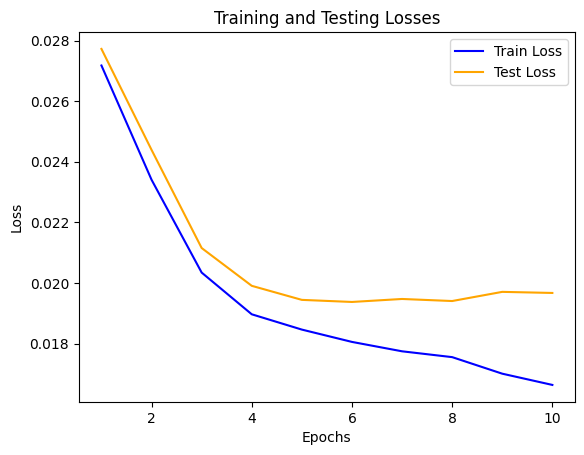

In [9]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## v distribution

### Training Data

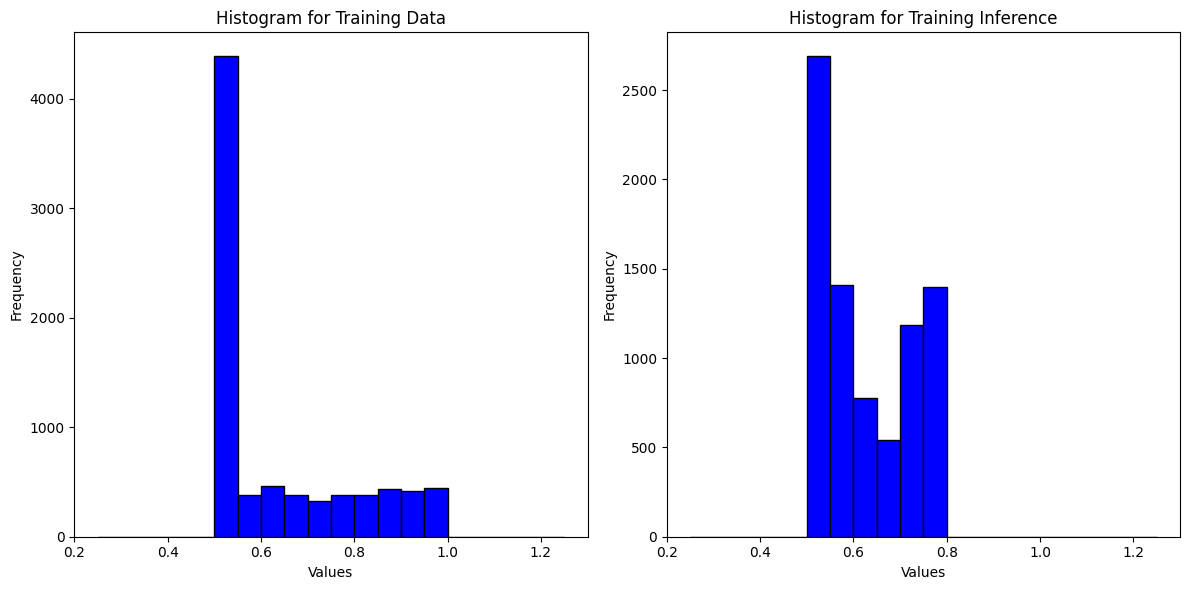

In [10]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for inputs, targets in train_loader:
        train_loader_v += targets.numpy().squeeze().tolist()
        train_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

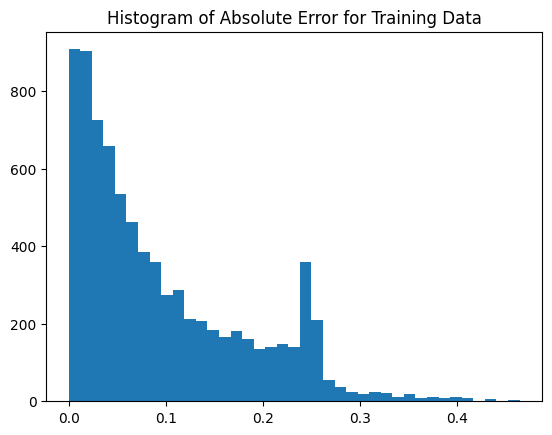

In [11]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

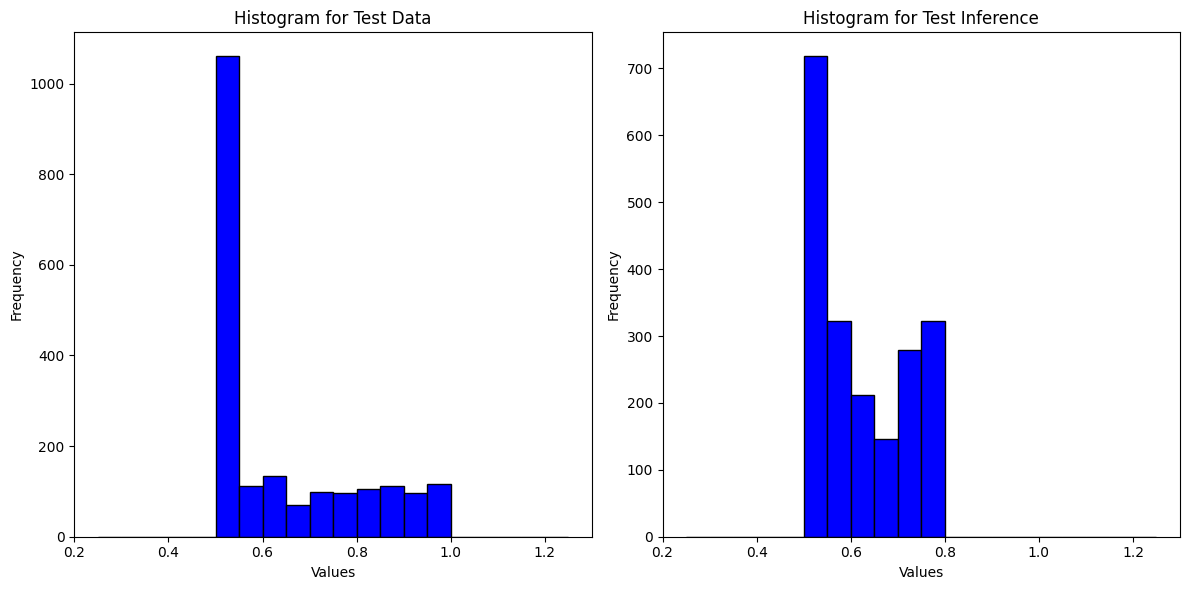

In [12]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for inputs, targets in test_loader:
        test_loader_v += targets.numpy().squeeze().tolist()
        test_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

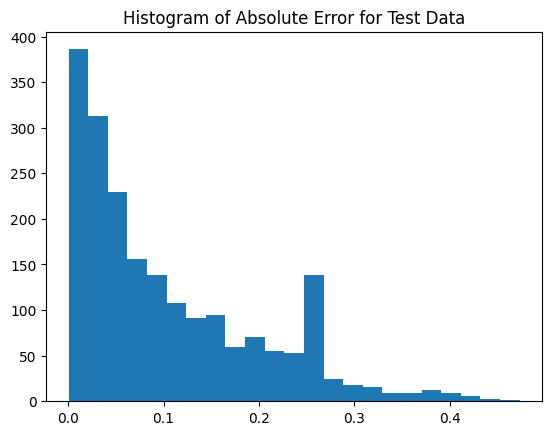

In [13]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [14]:
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')
v_thresh_dir = os.path.join(data_dir, 'v_thresh')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]
v_thresh_data = [np.loadtxt(os.path.join(v_thresh_dir, f)) 
                            for f in os.listdir(v_thresh_dir) if f.startswith('v_thresh') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')
v_thresh_dir = os.path.join(data_dir, 'v_thresh')

phi_data = [np.loadtxt(os.path.join(phi_dir, f))
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1 # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]
v_thresh_data = [np.loadtxt(os.path.join(v_thresh_dir, f))
                 for f in os.listdir(v_thresh_dir) if f.startswith('v_thresh') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
FDRs_opt = []  # or FDPs
TPRs_opt = []  # or TPPs
for phi, true_actives, v_thresh in zip(phi_data, true_actives_data, v_thresh_data):
    selected_opt = np.where(phi > v_thresh)[0]
    selected_actives_opt = np.intersect1d(selected_opt, true_actives, assume_unique=True)
    selected_null_opt = np.setdiff1d(selected_opt, selected_actives_opt, assume_unique=True)
    FDRs_opt.append(len(selected_null_opt) / max(len(selected_opt), 1))
    TPRs_opt.append(len(selected_actives_opt) / max(len(true_actives), 1))
    
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

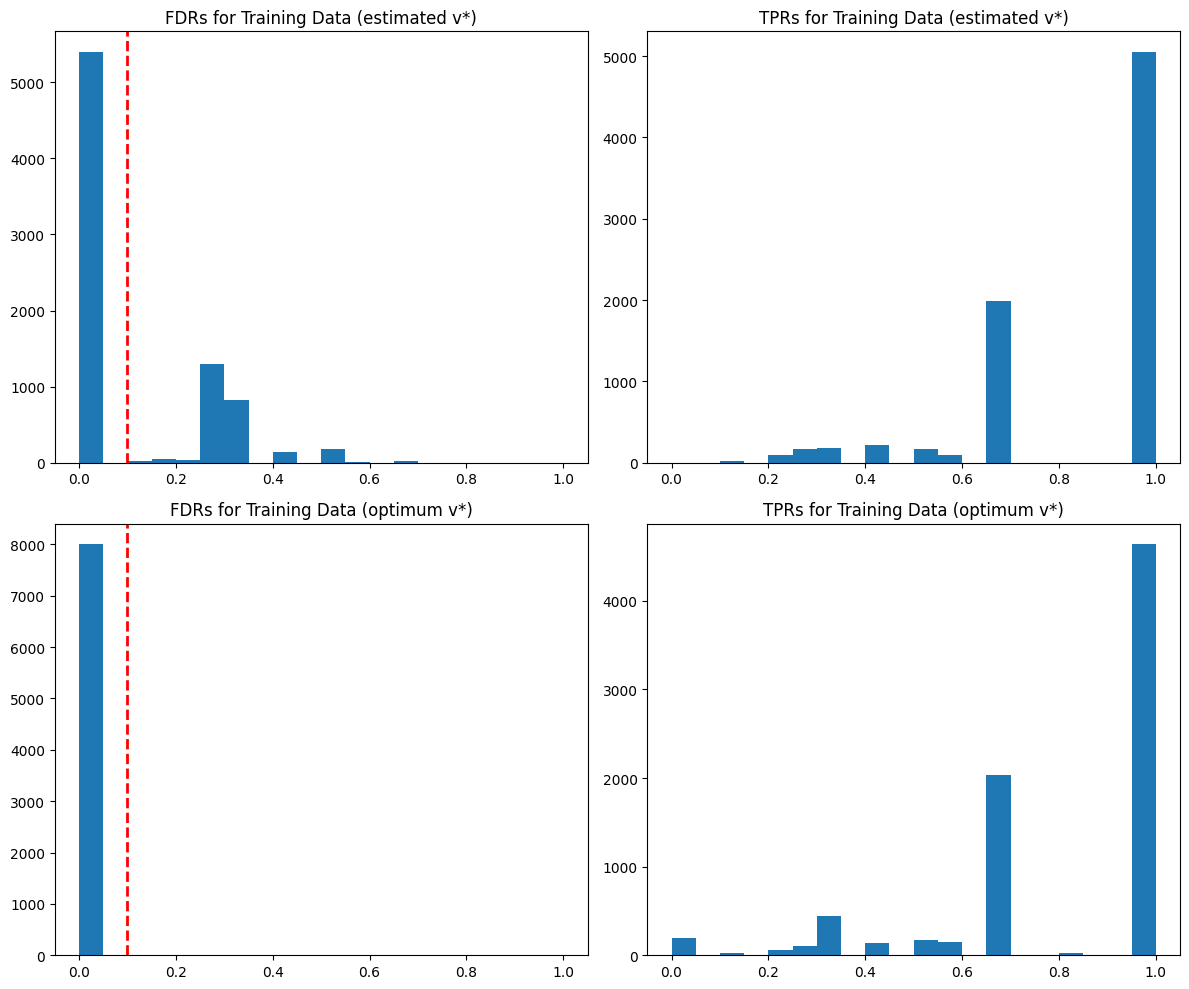

In [15]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(np.array(FDRs)[train_indices], bins=bins)
axs[0, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0, 0].set_title("FDRs for Training Data (estimated v*)")

axs[0, 1].hist(np.array(TPRs)[train_indices], bins=bins)
axs[0, 1].set_title("TPRs for Training Data (estimated v*)")

axs[1, 0].hist(np.array(FDRs_opt)[train_indices], bins=bins)
axs[1, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[1, 0].set_title("FDRs for Training Data (optimum v*)")

axs[1, 1].hist(np.array(TPRs_opt)[train_indices], bins=bins)
axs[1, 1].set_title("TPRs for Training Data (optimum v*)")

plt.tight_layout()

plt.show()

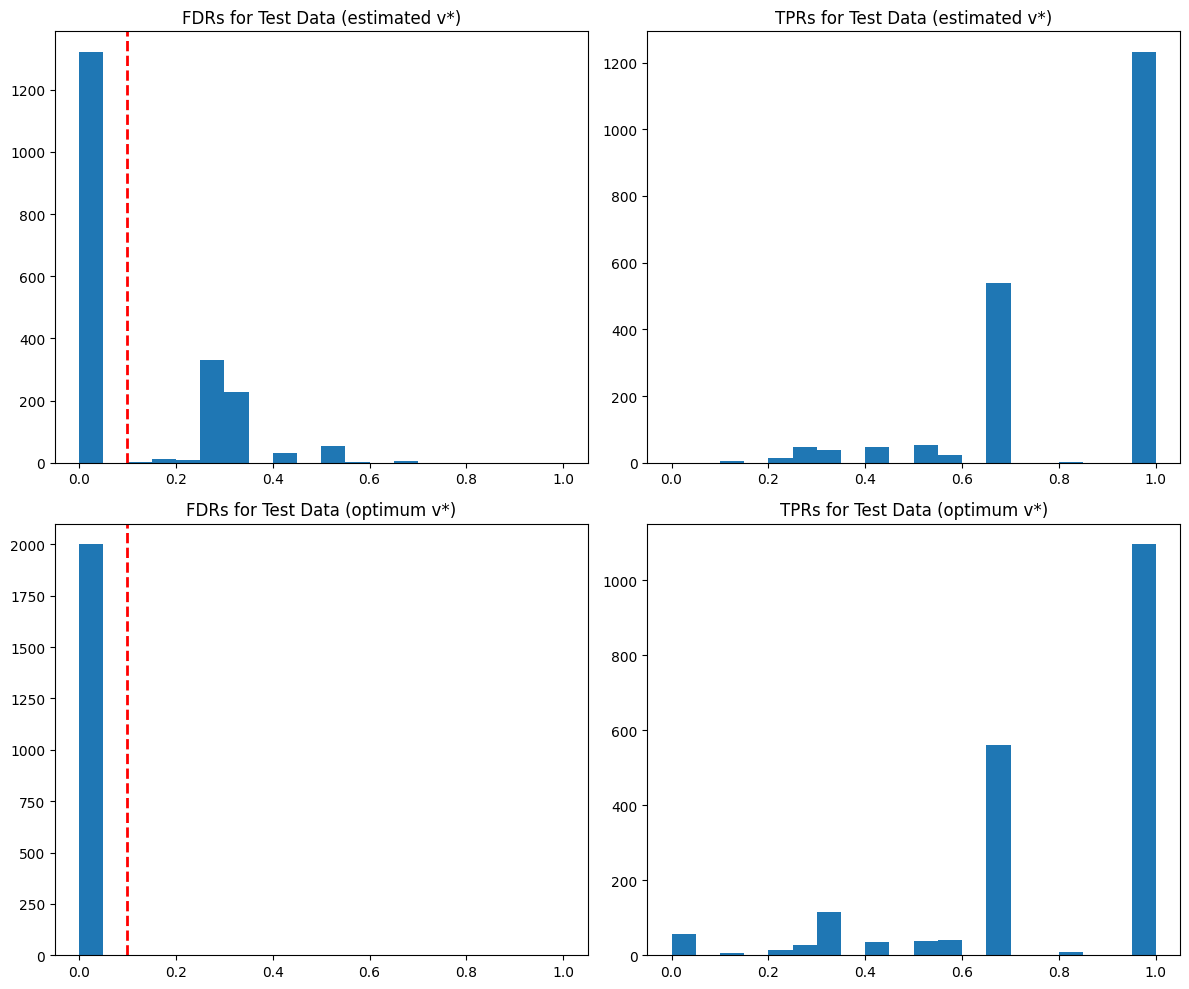

In [16]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(np.array(FDRs)[test_indices], bins=bins)
axs[0, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0, 0].set_title("FDRs for Test Data (estimated v*)")

axs[0, 1].hist(np.array(TPRs)[test_indices], bins=bins)
axs[0, 1].set_title("TPRs for Test Data (estimated v*)")

axs[1, 0].hist(np.array(FDRs_opt)[test_indices], bins=bins)
axs[1, 0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[1, 0].set_title("FDRs for Test Data (optimum v*)")

axs[1, 1].hist(np.array(TPRs_opt)[test_indices], bins=bins)
axs[1, 1].set_title("TPRs for Test Data (optimum v*)")

plt.tight_layout()

plt.show()